In [1]:
# Cargamos datos
import Loading_data 

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
comunidad


,Lugar,Casos,Casos hoy absoluto,Casos hoy variacion diferencia,Casos hoy porcentaje,Fallecidos,Fallecidos hoy absoluto,Fallecidos hoy variacion diferencia,Fallecidos hoy porcentaje,Curados,UCI,Hospitalizados
Fecha,,,,,,,,,,,,
2020-03-26,Madrid,17166,2569,324,0.149656,2090,265,-25,0.126794,3882,1221,12440
2020-03-25,Madrid,14597,2245,468,0.153799,1825,290,18,0.158904,3031,1150,11153
2020-03-24,Madrid,12352,1777,904,0.143863,1535,272,30,0.177199,2291,1050,10443
2020-03-23,Madrid,10575,873,92,0.082553,1263,242,25,0.191607,2063,942,9561
2020-03-22,Madrid,9702,781,-975,0.080499,1021,217,41,0.212537,0,834,8441
2020-03-21,Madrid,8921,1756,1368,0.196839,804,176,46,0.218905,0,767,7388
2020-03-20,Madrid,7165,388,-752,0.054152,628,130,22,0.207006,0,678,0
2020-03-19,Madrid,6777,1140,374,0.168216,498,108,73,0.216867,0,590,0
2020-03-18,Madrid,5637,766,60,0.135888,390,35,-107,0.089744,0,491,0


Fecha
2020-03-26    0.126794
2020-03-25    0.158904
2020-03-24    0.177199
2020-03-23    0.191607
2020-03-22    0.212537
2020-03-21    0.218905
2020-03-20    0.207006
2020-03-19    0.216867
2020-03-18    0.089744
2020-03-17    0.400000
2020-03-16    0.619718
2020-03-13    0.308642
2020-03-12    0.446429
2020-03-11    0.322581
2020-03-10    0.619048
2020-03-09    0.750000
2020-03-06    0.500000
2020-03-05         NaN
Name: Fallecidos hoy porcentaje, dtype: float64

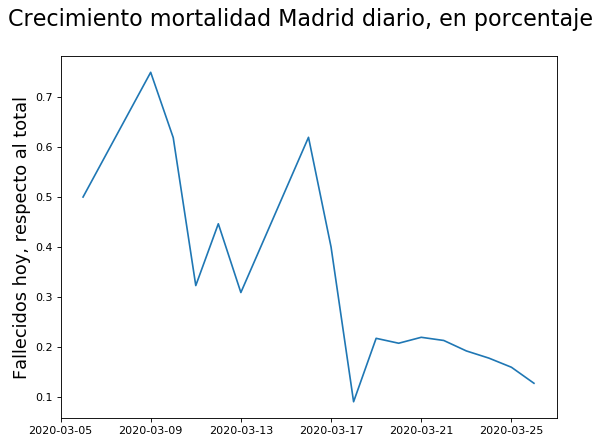

In [2]:
# Grafica

from matplotlib import pyplot as plt    



fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot( comunidad['Fallecidos hoy porcentaje'])
fig.suptitle('Crecimiento mortalidad '+COMUNIDAD_A_CONSIDERAR+' diario, en porcentaje', fontsize=20)
plt.ylabel('Fallecidos hoy, respecto al total', fontsize=16)

comunidad['Fallecidos hoy porcentaje']

Fecha
2020-03-26    265
2020-03-25    290
2020-03-24    272
2020-03-23    242
2020-03-22    217
2020-03-21    176
2020-03-20    130
2020-03-19    108
2020-03-18     35
2020-03-17    142
2020-03-16    132
2020-03-13     25
2020-03-12     25
2020-03-11     10
2020-03-10     13
2020-03-09      6
2020-03-06      1
2020-03-05      0
Name: Fallecidos hoy absoluto, dtype: int64

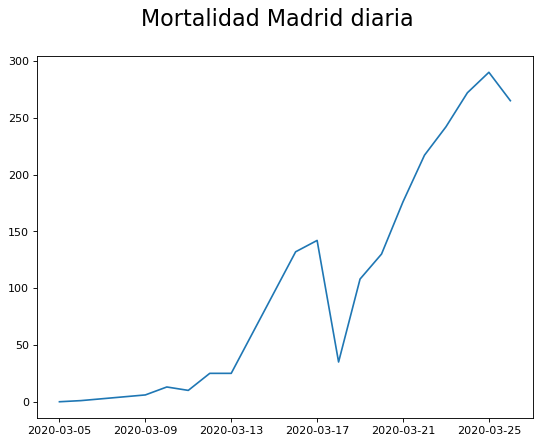

In [3]:
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot(comunidad['Fallecidos hoy absoluto']) 
fig.suptitle('Mortalidad '+COMUNIDAD_A_CONSIDERAR+' diaria', fontsize=20)

comunidad['Fallecidos hoy absoluto']

In [4]:
import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()


In [5]:
import pandas as pd


def Get_Dimensions_All_CCAA(Atributos):
    array = []
    for ca in COMUNIDADES: 
        comunidad = Loading_data.Get_Comunidad(ca).head(1)
        comunidad = comunidad.reset_index() # Resets the index, makes factor a column
        temp_dict = {}
        temp_dict['Lugar'] = ca
        for attr in Atributos:
            temp_dict[attr] = comunidad[attr].iloc[0]
        array.append(temp_dict)

    return pd.DataFrame.from_records(array)



In [6]:

    
    
def Print_Two_Cordinates_CCAA(df):
    fig,ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    for k,d in df.groupby('Lugar'):
        ax.scatter(d[df.columns[1]], d[df.columns[2]], label=k)

    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

    ax.set_xlabel(df.columns[1])
    ax.set_ylabel(df.columns[2])
    ax.set_title(df.columns[1]+ ' VS. ' + df.columns[2])
    return plt





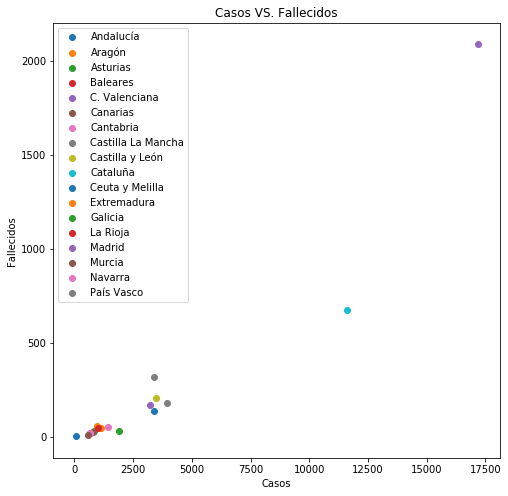

,Lugar,Casos,Fallecidos
9,Ceuta y Melilla,49,1
14,Murcia,596,8
3,Baleares,660,17
5,Cantabria,671,17
4,Canarias,784,24
2,Asturias,841,27
11,Extremadura,969,58
17,La Rioja,995,43
1,Aragón,1116,48
15,Navarra,1411,49


In [7]:

Atributos = ['Casos', 'Fallecidos']
df = Get_Dimensions_All_CCAA(Atributos)
plt = Print_Two_Cordinates_CCAA(df)
plt.show()
df.sort_values(by=[df.columns[1],df.columns[2]])

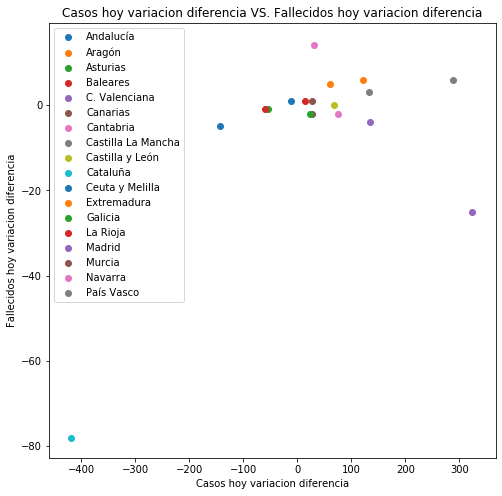

,Lugar,Casos hoy variacion diferencia,Fallecidos hoy variacion diferencia
8,Cataluña,-418,-78
0,Andalucía,-143,-5
17,La Rioja,-59,-1
2,Asturias,-55,-1
9,Ceuta y Melilla,-11,1
3,Baleares,14,1
12,Galicia,24,-2
4,Canarias,27,-2
14,Murcia,27,1
15,Navarra,31,14


In [8]:
Atributos = ['Casos hoy variacion diferencia', 'Fallecidos hoy variacion diferencia']
df = Get_Dimensions_All_CCAA(Atributos)
plt = Print_Two_Cordinates_CCAA(df)
plt.show()
df.sort_values(by=[df.columns[1],df.columns[2]])